## Importation Library, global variable and Functions

In [1]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
from scipy import signal
import scipy.cluster.hierarchy as spc
from pandas import read_excel
from ipywidgets import widgets
from ipywidgets import interactive, HBox, VBox
import plotly.io as pio
import seaborn as sns
import numpy as np
import os
import plotly.express as px
from sklearn.cluster import KMeans

In [2]:
country_list = ["FR","BE","BG","CY","CZ","DE","DK","EE","ES","FI","AT","GB","GR","HR","HU","IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"]
country_list_iso = ["FRA","BEL","BGR","CYP","CZE","DEU","DNK","EST","ESP","FIN","AUT","GBR","GRC","HRV","HUN","IRL","ITA","LTU","LUX","LVA","MLT","NLD","POL","PRT","ROU","SWE","SVN","SVK"]

### Functions definitions

In [3]:
#cluster countries based on correlation measure
def getIdx(corr,variableTweak):
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    idx = spc.fcluster(linkage, variableTweak * pdist.max(), 'distance')
    return idx

def getGroupe(number,idx):
    groupe = []
    for i in range(0,len(idx)):
        x = idx[i]
        if x == number:
            groupe.append(i)
    return groupe

def plotDifferentGroup(idx,dfPlot,indicePlot, title):
    for i in range(1,max(idx)+1):
        df1 = dfPlot[dfPlot.columns[getGroupe(i,idx)]]
        plot_lines(df1,indicePlot, title)

def plotMapStatic(idx, title):
    fig = go.Figure(data=go.Choropleth(
        locations=country_list_iso, # Spatial coordinates
        z = idx, # Data to be color-coded
        locationmode = 'ISO-3', # set of locations match entries in `locations`
        colorscale="Blugrn",
        colorbar_title = "Millions USD",
        showscale = False,
    ))

    fig.update_layout(
        title_text = title,
        geo_scope='europe', # limite map scope to USA
        autosize=False,
        width=800,
        height=800,
        dragmode=False
    )
    fig.show()
    
def plotByGroup(df, title, threshold=0.5, method='hierarchical', n_clusters=3):
    df_corr= df.corr(method='kendall')
    idx = None
    if method== 'hierarchical':
        idx = getIdx(df_corr, threshold)
    else:
        idx=getKMeansGroups(df, n_clusters)+1
    plotDifferentGroup(idx, df, 11, title)
    plotMapStatic(idx, 'Clustering by interest on subject')
    
    
def getKMeansGroups(df, n_clusters=3):
    k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(df.transpose().values)
    return k_means.predict(df.transpose().values)

In [4]:
def plot_lines(df,value_smooth, title):
    fig = go.Figure()
    for x in df.columns:
        if value_smooth == 0:
            fig.add_trace(go.Scatter(x=df.index, y=df[x], mode='lines',name=x))
        else:
            fig.add_trace(go.Scatter(x=df.index, y=signal.savgol_filter(df[x],value_smooth, 3), mode='lines',name=x))
    fig.update_layout(title_text=title)
    fig.show()

In [5]:
def plotMapSlider(data,title,zMax,zMin,colorbarTitle,vWidth,vHeight):
    data_slider = []
    for ix in range(0,17):
        data_one_year = dict(
                            type='choropleth',
                            locations=country_list_iso, # Spatial coordinates
                            z = data[country_list].iloc[ix],
                            locationmode = 'ISO-3', # set of locations match entries in `locations`
                            autocolorscale=False,
                            colorscale = "Blugrn",
                            zmax = zMax,
                            zmin = zMin,
                            colorbar_title = colorbarTitle,
                            )
        ix = ix+1
        data_slider.append(data_one_year) 
    steps = []

    for i in range(len(data_slider)):
        step = dict(method='restyle',args=['visible', [False] * len(data_slider)],label=data.index[i].strftime("%m/%d/%Y"))
        step['args'][1][i] = True
        steps.append(step)

    #create 'sliders' object from the 'steps' 
    sliders = [dict(active=0, pad={"t": 1}, steps=steps)] 

    layout = dict(geo=dict(scope='europe',),sliders=sliders,title_text = title,autosize=False, width=vWidth,height=vHeight,dragmode = False,)
    fig = dict(data=data_slider, layout=layout,) 
    pio.show(fig)

In [6]:
def plotGlobalTrend(dfPlot,smooth,title):
    new_dfPlot = dfPlot.copy()
    new_dfPlot.loc[:,"Total norm"] = new_dfPlot.sum(axis=1)/new_dfPlot.shape[1]
    
    fig = go.Figure()
    df = new_dfPlot.loc[:,"Total norm"]
    if smooth == 0:
        fig.add_trace(go.Scatter(x=df.index, y=df, mode='lines',name=x))
    else:
        fig.add_trace(go.Scatter(x=df.index, y=signal.savgol_filter(df,smooth, 3), mode='lines',name="Global"))
    fig.update_layout(title_text="Global tendancy Google search about Climate change/Global warming")
    fig.show()

# 0. Introduction

# 1. Meat Consumption in EU

This project consist of studying meat consumption in Europe and impact on it depending on different factors that will be discussed later on.

In order to complete that, we need to see how the 28 countries in the EU (European Union) consume meats (mutton/goat/poultry/beef/pig). 
Then, we will see how this consumption vary for some selected countries in the EU.

We decide to work with datas between 2004 and 2019 (whenever it is possible).


## 1.1 Meat Consumption of the 28 EU countries

Dataset used: https://data.oecd.org/agroutput/meat-consumption.htm

Let's use the above dataset in order to see how fluctuates meat consumption in the 28 EU countries.

In [7]:
path = 'data_aslam/' # TODO: change path

### Pre-processing of data

In [8]:
meat_consumption_path = path + 'DP_LIVE_23112019095726322.csv'
meat_consumption = pd.read_csv(meat_consumption_path)

In [9]:
# Remove useless columns
#  - column INDICATOR contains only 'MEATCONSUMP', so we can remove it
#  - column Flag Codes contains only NaN, so we can remove it
#  - column FREQUENCY contains only A's
meat_consumption = meat_consumption.drop(columns = ['INDICATOR', 'Flag Codes', 'FREQUENCY'])

Measure are either in:
- KG_CAP (Kilogram of retail weights per capita)
- THND_TONNE (Thousand tonnes of carcass weights)

We choose to take *KG_CAP*:

In [10]:
meat_consumption = meat_consumption[meat_consumption['MEASURE'] == 'KG_CAP']

In [11]:
meat_consumption = meat_consumption[ (meat_consumption['TIME'] >= 2004) & (meat_consumption['TIME'] <= 2018)]

It appears that the dataset separated the United Kingdom from the EU countries because of the BREXIT. Since we want to work with the 28 EU countries, we need to selected only **'EU27'** and **'GBR'** (Great Britain) and merge the values in order to plot them:

In [12]:
meat_consumption = meat_consumption[ (meat_consumption['LOCATION'] == 'EU27') | (meat_consumption['LOCATION'] == 'GBR')]

In order combine 'EU27' and 'GBR', we need to take care of the proportionality between them. Indeed, if we just sum them, the displayed consumption will be the consumption of 1 citizen of EU27 additioned to the UK consumption which isn't what we want. 
To do that, we need to compute the ratio of British people among the 28 countries in EU and compute the adequate value to aggregate.

We need the [population](http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=demo_gind&lang=fr) size on this period to do this.

In [13]:
population_EU28_2004_2019 = [492555798, 494598322, 496436597, 498300775, 500297033, 502090235, 503170618, 502964837, 504047749, 505163053, 507235091, 508520205, 510181874, 511373278, 512379225]

In [14]:
population_UK_2004_2019 = [59793759, 60182050, 60620361, 61073279, 61571647, 62042343, 62510197, 63022532, 63495088, 63905342, 64351203, 64853393, 65379044, 65844142, 66273576]

We compute the ratio of the British people among the population in the EU28 (and EU27 among EU28):

In [15]:
UK_2004_2019_ratio = [x/y for x,y in zip(population_UK_2004_2019, population_EU28_2004_2019)]

In [16]:
population_EU27_2004_2019_ratio = [(x-y)/x for x,y in zip(population_EU28_2004_2019,population_UK_2004_2019)]

In [17]:
def ratio(row):
    """This function returns the correct ratio for a row depending on LOCATION and year"""
    if row['LOCATION'] == 'EU27':
        val = population_EU27_2004_2019_ratio[row['TIME'] - 2004]
    elif row['LOCATION'] == 'GBR':
        val = UK_2004_2019_ratio[row['TIME'] - 2004]
    return val

In [18]:
meat_consumption['ratio'] =  meat_consumption.apply(ratio, axis=1)
meat_consumption['Value'] = meat_consumption['ratio'] * meat_consumption['Value']

In [19]:
meat_consumption = meat_consumption.groupby(['TIME', 'SUBJECT'])['Value'].sum().unstack(level=1)

In order to get the overall consumption of meat (all meats mixed), we need to sum their quantities (since we just adapted the values with their appropriate ratios). 


Meanwhile, we need to take care about a fact:

["Carcass weight to retail weight conversion factors are: 0.7 for beef and veal, 0.78 for pigmeat, and 0.88 for both sheep meat and poultry meat."](https://data.oecd.org/agroutput/meat-consumption.htm)

In [20]:
meat_consumption['all_consumption'] = ( 
                                    (0.7 * meat_consumption['BEEF']) +
                                    (0.78 * meat_consumption['PIG']) +
                                    (0.88 * (meat_consumption['SHEEP'] + meat_consumption['POULTRY'])))

In [21]:
meat_consumption['years'] = meat_consumption.index

### Plot

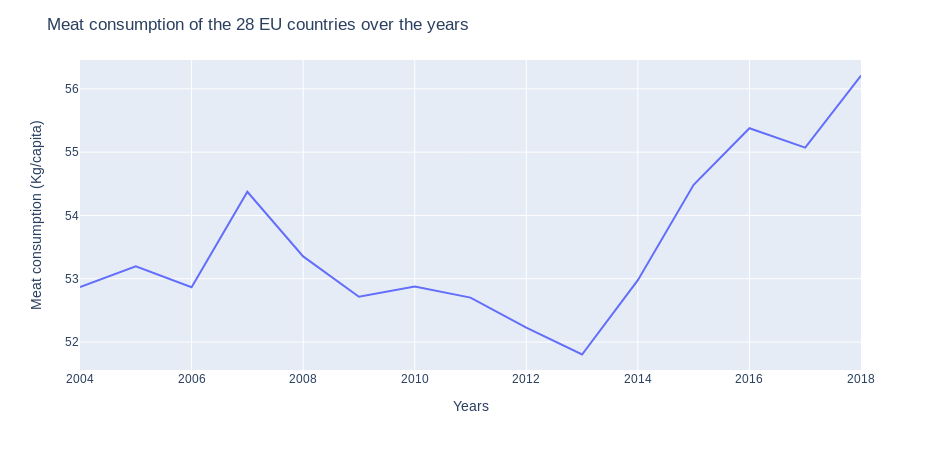

In [22]:
fig = px.line(meat_consumption, x='years', y='all_consumption')
fig.update_xaxes(title_text='Years')
fig.update_yaxes(title_text='Meat consumption (Kg/capita)')
fig.update_layout(title_text = 'Meat consumption of the 28 EU countries over the years',)
fig.show()

Here, we can see that before 2007, the consumption increases and then drop until 2013.
Then, meat consumption drastically increases until 2018.

However, it could be interesting to see the trends specifically for some countries to have a closer look at the consumption changes.

## 1.2 Variation for some selected countries in EU

In order to get more details about the meat consumption in EU, we need to have a look per country.

There is a [dataset (FAO)](http://www.fao.org/faostat/en/?#data/FBS/visualize) that contains such data for every country in the EU but only before 2013.

Hence, we decide to find data for some selected countries from 2004 to 2018 elsewhere to compare them.

We will use the **kg/person** unit to compare the consumption to avoid getting disturbed by the size of the population for the countries.

We will first see the meat consumption for these countries and then see the variation considering 2004 as the base value and see how the consumption changed (compared to 2004).

Let's do it with the following countries:
- United Kingdom
- Germany
- Portugal
- France
- Slovakia
- Slovenia
- Sweden
- Poland

and then we will see the meat consumption of these countries over time and their variation.

*(The following function will be used to compute variation between years from 2004. It returns the base value:)*

In [23]:
# Function to get the first value the dataset (2004)
def  get_value_of_2004(df):
    return df[ (df['years'] == 2004)]['meat consumption (kg/person)'].values[0]

### 1.2.1 UK meat consumption (United Kingdom)

As you saw before, we needed to aggregate *'United Kingdom'* values before since the dataset separated it. We can just purely use these data:

In [24]:
uk_meat_consumption = pd.read_csv(meat_consumption_path)

uk_meat_consumption = uk_meat_consumption[uk_meat_consumption['MEASURE'] == 'THND_TONNE']
uk_meat_consumption = uk_meat_consumption[ (uk_meat_consumption['TIME'] >= 2004) & (uk_meat_consumption['TIME'] < 2019)]
uk_meat_consumption = uk_meat_consumption[ (uk_meat_consumption['LOCATION'] == 'GBR')]

In [25]:
uk_meat_consumption = uk_meat_consumption.groupby(['TIME', 'SUBJECT'])['Value'].sum().unstack(level=1)
uk_meat_consumption['all_consumption'] = ( 
                                    (0.7 * uk_meat_consumption['BEEF']) +
                                    (0.78 * uk_meat_consumption['PIG']) +
                                    (0.88 * (uk_meat_consumption['SHEEP'] + uk_meat_consumption['POULTRY'])))
uk_meat_consumption['years'] = uk_meat_consumption.index

In [26]:
uk_population_from_2004_to_2018_in_billions = [59.95, 60.41, 60.83, 61.32, 61.82, 62.26, 62.76, 63.18, 63.7, 64.11, 64.6, 65.11, 65.65, 66.04, 66.44]
uk_meat_consumption['population'] = uk_population_from_2004_to_2018_in_billions

In [27]:
# dividing thousands of tons (1'000 tonnes == 1'000'000 kg) by population (in millions) will give us kg/person
uk_meat_consumption['meat consumption (kg/person)'] = uk_meat_consumption['all_consumption']/uk_meat_consumption['population']

In [28]:
# unecessary columns
columns_to_drop = ['BEEF', 'PIG', 'POULTRY', 'SHEEP', 'all_consumption', 'population']
uk_meat_consumption = uk_meat_consumption.drop(columns = columns_to_drop)

In [29]:
uk_meat_consumption['Area'] = 'United Kingdom'

In [30]:
# Variation column
value_to_sub = get_value_of_2004(uk_meat_consumption)
uk_meat_consumption['Variation'] = uk_meat_consumption['meat consumption (kg/person)'] - value_to_sub

### 1.2.2 DE meat consumption (Germany)

In order to get these datas, we need to merge two datasets:

- From 2004 to 2008: [link](http://www.fao.org/faostat/en/?#data/FBS/visualize)

- From 2008: [link](https://de.statista.com/statistik/daten/studie/36573/umfrage/pro-kopf-verbrauch-von-fleisch-in-deutschland-seit-2000/)

Population data: [Eurostat](https://ec.europa.eu/eurostat/en/web/population-demography-migration-projections/statistics-illustrated)

We used the overlap years between these two datasets to be sure that data is consistent.

In [31]:
# extracted data
data = [[2004, 84.4],[2005, 83.9],[2006, 84.3],[2007, 87.9],[2008, 89.8],[2009, 90.1],[2010, 91.2],[2011, 91.4],[2012, 88.8],[2013, 89],[2014, 89.4],[2015, 89.9],[2016, 89.8],[2017, 88.1],[2018, 88.6]]

In [32]:
germany_meat_consumption = pd.DataFrame(data, columns = ['years', 'meat consumption (kg/person)']) 
# add Germany as country
germany_meat_consumption['Area'] = 'Germany'

In [33]:
# create Variation column
value_to_sub = get_value_of_2004(germany_meat_consumption)
germany_meat_consumption['Variation'] = germany_meat_consumption['meat consumption (kg/person)'] - value_to_sub

### 1.2.3 PT meat consumption (Portugal)

Same principle as for the german datasets:

- From  2004 to 2013: [link](http://www.fao.org/faostat/en/?#data/FBS/visualize)

- From 2014: [link](https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&contecto=pi&indOcorrCod=0000211&selTab=tab0)

Population data: [Eurostat](https://ec.europa.eu/eurostat/en/web/population-demography-migration-projections/statistics-illustrated)

Again: We used the overlap years between these two datasets to be sure that data is consistent.

In [34]:
data = [[2004, 906/10.47],[2005, 918/10.49],[2006, 947/10.51],[2007, 1022/10.53],[2008, 1010/10.55],[2009, 1020/10.56],[2010, 1019/10.57],[2011, 986/10.57],[2012, 965/10.54],[2013, 966/10.49],[2014, 108.2],[2015, 111.2],[2016, 113.0],[2017, 113.8],[2018, 117.4]]

In [35]:
# Create the pandas DataFrame 
portugal_meat_consumption = pd.DataFrame(data, columns = ['years', 'meat consumption (kg/person)']) 
# add Portugal as country
portugal_meat_consumption['Area'] = 'Portugal'

In [36]:
# create Variation column
value_to_sub = get_value_of_2004(portugal_meat_consumption)
portugal_meat_consumption['Variation'] = portugal_meat_consumption['meat consumption (kg/person)'] - value_to_sub

### 1.2.4 FR meat consumption (France)

Dataset: [link](https://www.franceagrimer.fr/Eclairer/Etudes-et-Analyses/Consommation-des-produits-carnes-en-2018)



In [37]:
french_consumption_path = path + 'fr_consumption.csv'
french_consumption = pd.read_csv(french_consumption_path)
# cleaning
french_consumption = french_consumption.drop(columns = ['nb Hab'])
# constructing (renaming)
french_consumption.columns = ['years', 'meat consumption (kg/person)']
french_consumption['Area'] = 'France'

In [38]:
# create Variation column
value_to_sub = get_value_of_2004(french_consumption)
french_consumption['Variation'] = french_consumption['meat consumption (kg/person)'] - value_to_sub

### 1.2.5 SVK meat consumption (Slovakia)

Dataset: [link](http://datacube.statistics.sk/#!/view/en/VBD_SLOVSTAT/ps2041rs/v_ps2041rs_00_00_00_en)

In [39]:
slovakia_consumption_path = path + 'slovakia_consumption_trial.csv'
# separator is ";"
slovakia_consumption = pd.read_csv(slovakia_consumption_path, sep=';')

In [40]:
# use only meat
slovakia_consumption = slovakia_consumption[ slovakia_consumption['INDEX'] == 'Meat total']

In [41]:
# drop useless columns (index, txt_value and all years before 2004)
columns_to_drop = ['INDEX', 'TXT_VALUE']
columns_to_drop += [str(x) for x in range(1990, 2004)]

# years column to keep
years_column = [str(x) for x in range(2004, 2019)]
slovakia_consumption.drop(columns=columns_to_drop)

# we need to melt in order to have the years inside a column instead of a column per year
slovakia_consumption = pd.melt(slovakia_consumption.drop(columns=columns_to_drop), id_vars=[], value_vars=years_column)
slovakia_consumption.columns = ['years', 'meat consumption (kg/person)']
slovakia_consumption['Area'] = 'Slovakia'

# convert to float (cleaning since dataset contained commas instead of dots on values)
slovakia_consumption['meat consumption (kg/person)'] = [float(el.replace(',','.')) for el in slovakia_consumption['meat consumption (kg/person)']]

In [42]:
# must do it to compare them while building variation (comparison between ints)
slovakia_consumption['years'] = slovakia_consumption['years'].apply(lambda x: int(x))

In [43]:
# create Variation column
value_to_sub = get_value_of_2004(slovakia_consumption)
slovakia_consumption['Variation'] = slovakia_consumption['meat consumption (kg/person)'] - value_to_sub

### 1.2.6 SVN meat consumption (Slovenia)

Dataset: [visualize](https://www.stat.si/StatWeb/en/News/Index/8111), [data](https://pxweb.stat.si/SiStatDb/pxweb/sl/30_Okolje/30_Okolje__15_kmetijstvo_ribistvo__12_prehranske_bilance__02_15635_koled_bilance/1563501S.px/)

In [44]:
slovenia_consumption_path = path + 'slovenia_consumption.csv'
slovenia_consumption = pd.read_csv(slovenia_consumption_path, sep='\t')

In [45]:
years_column = [x for x in range(2004, 2019)]
slovenia_consumption.columns = years_column

In [46]:
slovenia_consumption = pd.melt(slovenia_consumption, id_vars=[], value_vars=years_column)
slovenia_consumption.columns = ['years', 'meat consumption (kg/person)']
slovenia_consumption['Area'] = 'Slovenia'

In [47]:
# create Variation column
value_to_sub = get_value_of_2004(slovenia_consumption)
slovenia_consumption['Variation'] = slovenia_consumption['meat consumption (kg/person)'] - value_to_sub

### 1.2.7 SWE meat consumption (Sweden)

Dataset: [link](http://statistik.sjv.se/PXWeb/pxweb/sv/Jordbruksverkets%20statistikdatabas/Jordbruksverkets%20statistikdatabas__Konsumtion%20av%20livsmedel/JO1301K2.px/?rxid=5adf4929-f548-4f27-9bc9-78e127837625)

In [48]:
sweden_consumption_path = path + 'sweden_meat_consumption_total.csv'
sweden_consumption = pd.read_csv(sweden_consumption_path, sep = ";")

In [49]:
sweden_consumption = sweden_consumption.dropna().drop(columns=['Tabelluppgifter'])
# only have until 2017
years_column = [str(x) for x in range(2004, 2018)] 
sweden_consumption = pd.melt(sweden_consumption, id_vars=[], value_vars=years_column)

In [50]:
sweden_consumption.columns = ['years', 'meat consumption (kg/person)']
sweden_consumption['years'] = sweden_consumption['years'].apply(lambda x: int(x))

In [51]:
sweden_consumption['Area'] = 'Sweden'

In [52]:
# create Variation column
value_to_sub = get_value_of_2004(sweden_consumption)
sweden_consumption['Variation'] = sweden_consumption['meat consumption (kg/person)'] - value_to_sub

### 1.2.8 POL meat consumption (Poland)

We need to combine two datasets:

- From  2004 to 2013: [link](http://www.fao.org/faostat/en/?#data/FBS/visualize)

- From 2014: [link](https://www.pigprogress.net/World-of-Pigs1/Articles/2019/2/Poland-Once-thriving-now-fragmented-387324E/)

Population: [worldometers](https://www.worldometers.info/world-population/poland-population/)

Again: We used the overlap years between these two datasets to be sure that data is consistent.

In [53]:
data = [[2004, 2968/38.4],[2005, 2949/38.37],[2006, 2961/38.35],[2007, 3036/38.35],[2008, 2927/38.35],[2009, 3002/38.35],[2010, 2987/38.32],[2011, 3038/38.28],[2012, 2941/38.23],[2013, 2968/38.16],[2014, 73.6],[2015, 75],[2016, 76]]

poland_consumption = pd.DataFrame(data, columns = ['years', 'meat consumption (kg/person)'])

In [54]:
poland_consumption['Area'] = 'Poland'

In [55]:
# create Variation column
value_to_sub = get_value_of_2004(poland_consumption)
poland_consumption['Variation'] = poland_consumption['meat consumption (kg/person)'] - value_to_sub

### 1.2.9 Merge above dataframes and plot 

In [56]:
all_frames = uk_meat_consumption.append([
    germany_meat_consumption,
    portugal_meat_consumption,
    french_consumption,
    slovakia_consumption,
    slovenia_consumption,
    sweden_consumption,
    poland_consumption],
    ignore_index=True, sort=False)

# cleaning data (some are str others are int/floats)
all_frames['years'] = all_frames['years'].apply(lambda x: int(x))
all_frames['meat consumption (kg/person)'] = all_frames['meat consumption (kg/person)'].apply(lambda x: float(x))

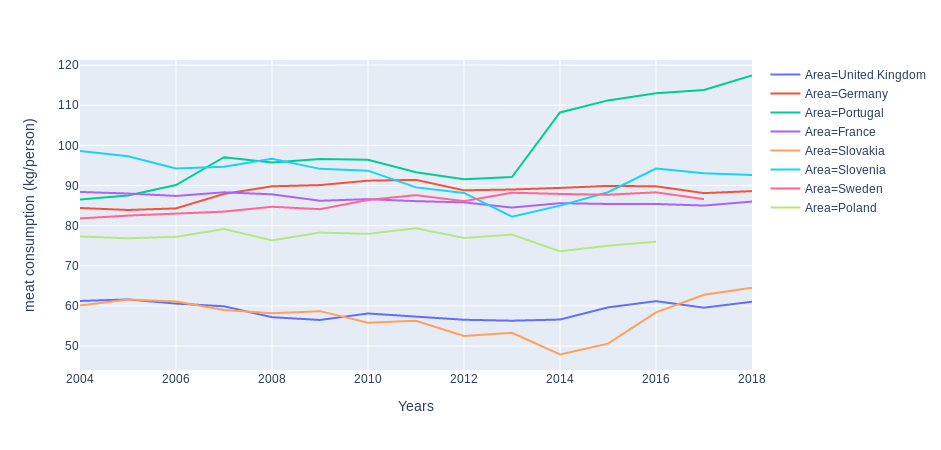

In [57]:
fig = px.line(all_frames, x="years", y='meat consumption (kg/person)', color='Area')
fig.update_xaxes(title_text='Years')
fig.update_yaxes(title_text='meat consumption (kg/person)')
fig.show()

In order to be able to see the variation, for each country, we will substract the value from 2004. Thus, we will have the variations after 2004 only and it will allow us to have see the variation in a map:

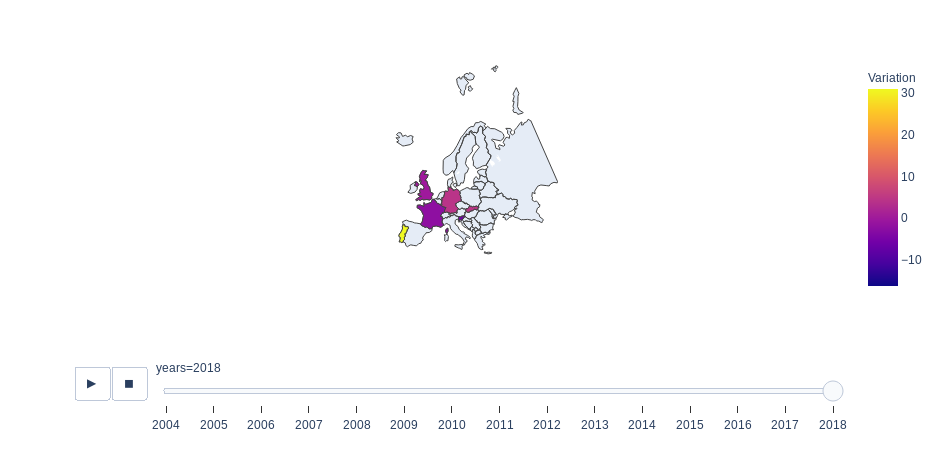

In [58]:
min_val = all_frames['Variation'].min()
max_val =  all_frames['Variation'].max()

fig = px.choropleth(all_frames, 
                    locations="Area", 
                    scope="europe", 
                    locationmode = 'country names', 
                    color='Variation', 
                    hover_name="Area", 
                    animation_frame="years", 
                    range_color=[min_val, max_val])
fig.show()

# 2. Climate Change awareness

Climate Change awareness of a population is difficult to measure. Due to a lack of survey to measure it, we use three different data to have a better look of the global trend of each EU country.

- Google Trend on "Climate change" and "Globalwarming" topics
- Eurobarometer a survey about "what do you think are the two most important issues facing the EU at the moment?"
- Media Coverage about Climate change in some EU Countries

## Google Trend

In [59]:
###
#find google data
###

pytrends = TrendReq(hl='en-US', tz=360)

#list topics 
climate_change_topic = ["/m/0cs9q"]
global_warming_topic = ["/m/0d063v"]
kw_list = [climate_change_topic,global_warming_topic]

#import every data from google trend 
for x in range(0, len(kw_list)):
    
    #adding just the first country 
    pytrends.build_payload(kw_list[x], cat=0, timeframe='all', geo=country_list[0], gprop='')
    pytrends.interest_over_time()
    newDataframe = pytrends.interest_over_time()[kw_list[x]]
    listColumn = []
    listColumn.append(country_list[0])
        
    #adding other country
    for y in range(1, len(country_list)): 
        pytrends.build_payload(kw_list[x], cat=0, timeframe='all', geo=country_list[y], gprop='')
        ledata = pytrends.interest_over_time()
        
        #verify if we have data
        if not ledata.empty:
            ledata.drop(ledata.columns[len(ledata.columns)-1], axis=1, inplace=True)
            newDataframe = pd.concat([newDataframe, ledata], axis=1, join='inner')
            listColumn.append(country_list[y])

    
    newDataframe.columns = listColumn
    
    #remove first 21 months because of strange values 
    newDataframe = newDataframe[21:] 
    newDataframe.to_pickle("./data_martin/GoogleTrend"+str(x)+".pkl") 

In [60]:
#Read pickles Data, 
df_climate_change = pd.read_pickle("./data_martin/GoogleTrend3.pkl")
df_global_warming = pd.read_pickle("./data_martin/GoogleTrend5.pkl")

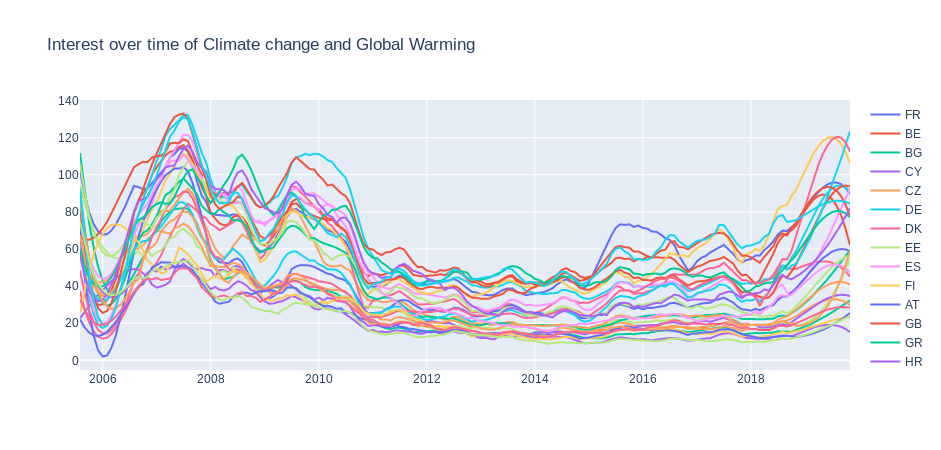

In [61]:
plot_lines(df_global_warming+df_climate_change,25,"Interest over time of Climate change and Global Warming ")

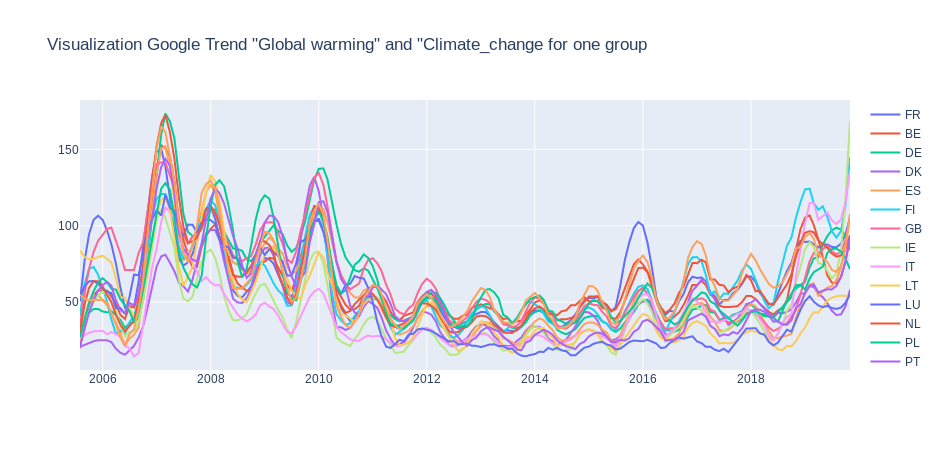

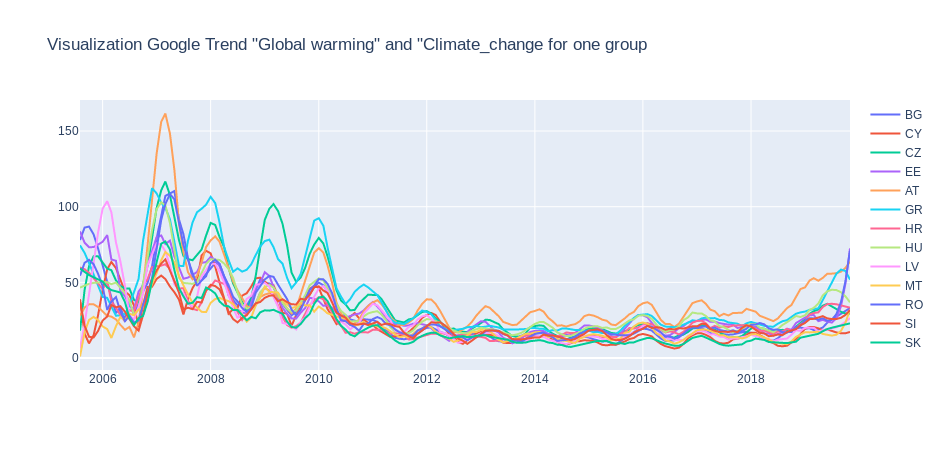

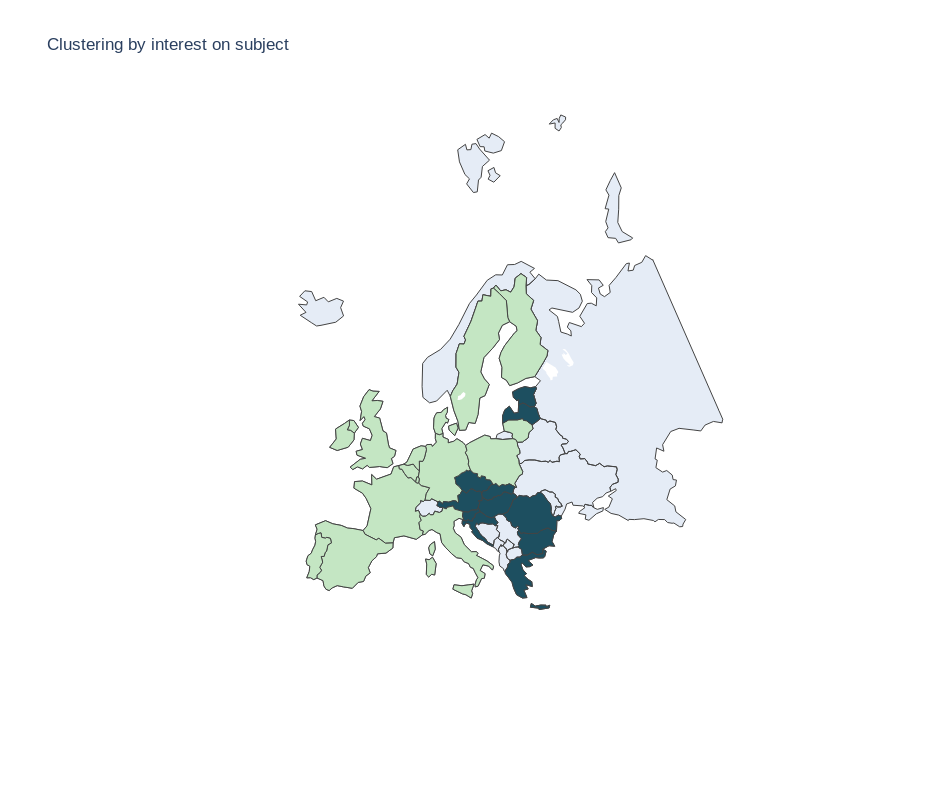

In [62]:
plotByGroup((df_climate_change+df_global_warming), 'Visualization Google Trend "Global warming" and "Climate_change for one group', n_clusters=2, method='kmeans')

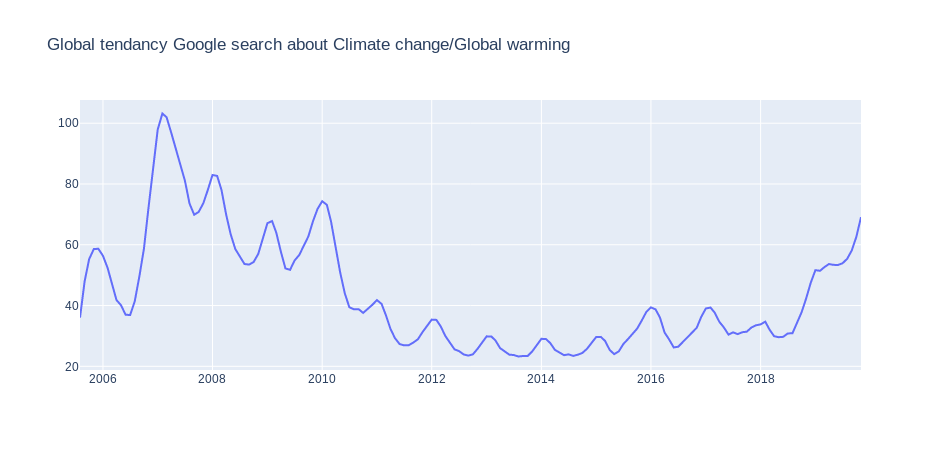

In [64]:
#Global tendancy about Climate change and Global Warming
plotGlobalTrend(df_global_warming+df_climate_change,15,"title");

## Eurobarometer

In [65]:
#importation data eurobarometer 
my_sheet = 'Sheet1'
file_name = "./data_martin/europa_survey/AT.xlsx"
df = read_excel(file_name, sheet_name = my_sheet)
eurobarometer = df[["Date"]]

for country in country_list:
    file_name = "./data_martin/europa_survey/"+country+".xlsx"
    df = read_excel(file_name, sheet_name = my_sheet)
    eurobarometer = pd.concat([eurobarometer, df[["Climate change"]]], axis=1, join='inner')

eurobarometer.columns = ["Date"]+country_list
eurobarometer.index = eurobarometer["Date"]
eurobarometer = eurobarometer.drop(['Date'], axis=1)

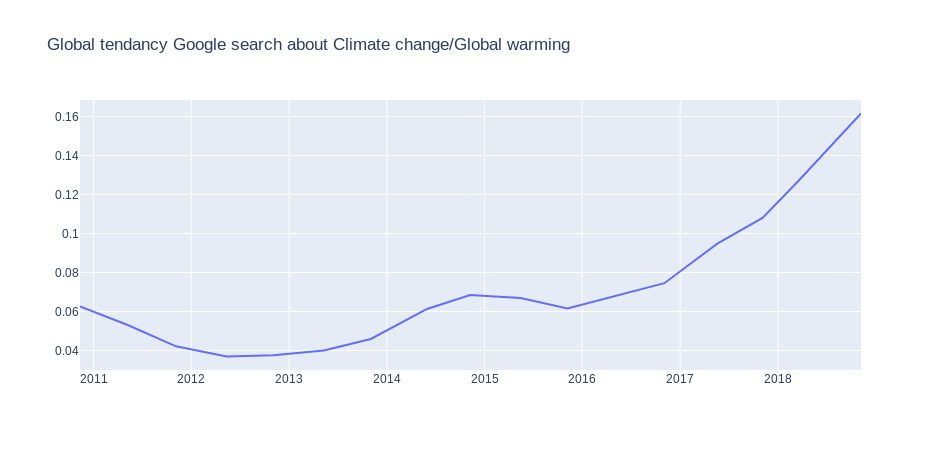

In [67]:
#Global trend about Eurobaromter 
plotGlobalTrend(eurobarometer,5,"title");

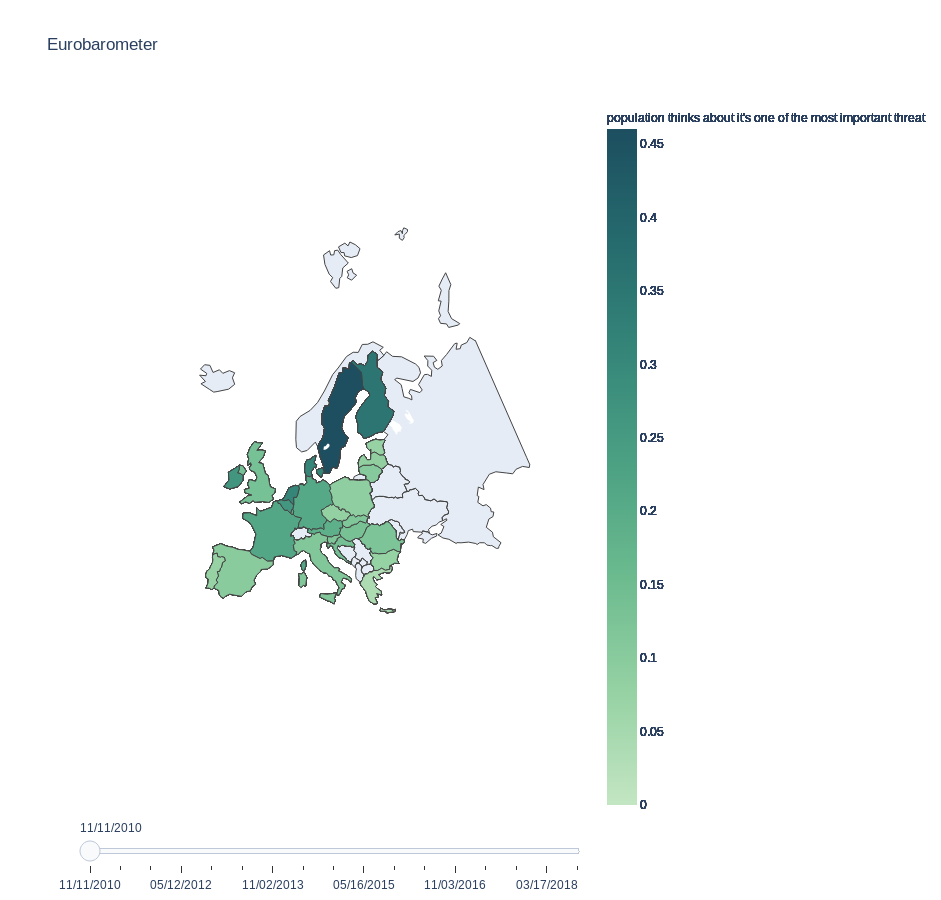

In [92]:
plotMapSlider(eurobarometer,"Eurobarometer",0.46,0," population thinks about it's one of the most important threat",1300,900)

## Media coverage

In [69]:
my_sheet = 'Sheet2'
file_name = "./data_martin/coverage_media.xlsx"
coverageMedia = read_excel(file_name, sheet_name = my_sheet)
coverageMedia = coverageMedia.T

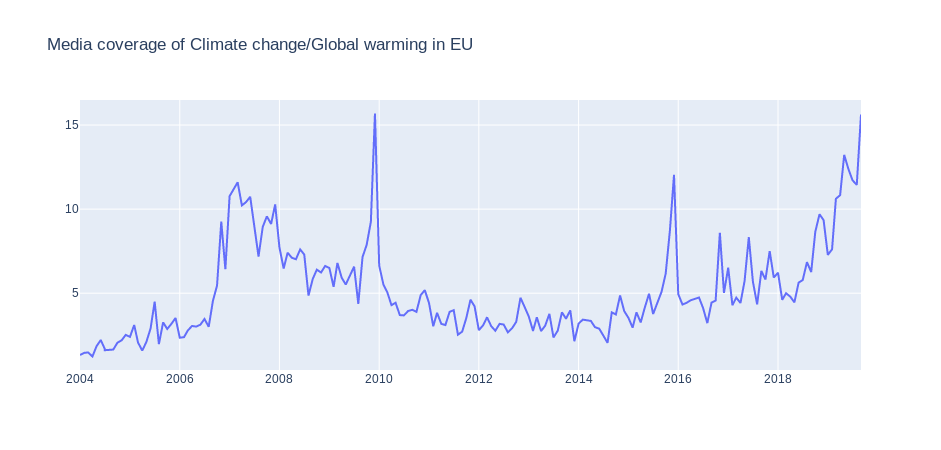

In [70]:
coverageMedia_norm = coverageMedia.copy()
for x in range(0,22):
        coverageMedia_norm.iloc[2:,x] = coverageMedia_norm.iloc[2:,x]/coverageMedia_norm.iloc[2:,x].max()
        
coverageMedia_norm.loc[:,"Total norm"] = coverageMedia_norm.sum(axis=1)

fig = go.Figure()
df = coverageMedia_norm.loc[:,"Total norm"]
fig.add_trace(go.Scatter(x=df.index, y=df, mode='lines',name=x))
fig.update_layout(title_text="Media coverage of Climate change/Global warming in EU")
fig.show()

# 3. Economic activity

Economic considerations could play a role in determining people's meat consumption. In this section we gather data relating to the global macroeconomic situation of a country as well as economic information relating to households.
The data is from OECD.



In [71]:
PATH_Q = "data_nico_quarterly/"
PATH_H = "data_nico_household/"
names_q = [name for name in os.listdir(PATH_Q) if ".csv" in name]
names_h = [name for name in os.listdir(PATH_H) if ".csv" in name]

In [72]:
def proc_cols(df, value_name):
    df = df.rename(columns={"Value": value_name})
    return df.drop(['INDICATOR', 'SUBJECT','MEASURE','FREQUENCY','Flag Codes'], axis=1)

def generate_df(csv_names,path):
    df = None
    str_end = len(".csv")
    for name in csv_names:
        if df is None:
            df = proc_cols(pd.read_csv(path+name),name[:-str_end])
        else:
            new_df = proc_cols(pd.read_csv(path+name),name[:-str_end])
            df = pd.merge(df, new_df,  how='outer', left_on=['LOCATION','TIME'], right_on = ['LOCATION','TIME'])
    return df

def df_date_format(df):
    return df.replace({'-Q1':'-01-01','-Q2':'-04-01','-Q3':'-07-01','-Q4':'-10-01'}, regex=True)

#adds date format and only starting from 2004
def df_date_format_yearly(df):
    df = df[df["TIME"] >= 2004].copy() #copy for warning
    df["TIME"] = df["TIME"].astype(str) + "-01-01"
    return df

We first gather information about unemployment and gdp growth as a proxy for the overall macroeconmic situation of countries (ie are they in a recession).

In [73]:
df = generate_df(names_q,PATH_Q)
df_hur = df_date_format(df[['LOCATION','TIME','HUR']])
df_gdp = df_date_format(df[['LOCATION','TIME','GDP_growth']])
df_hur = df_hur.pivot_table(values='HUR', index='TIME', columns='LOCATION')
df_gdp = df_gdp.pivot_table(values='GDP_growth', index='TIME', columns='LOCATION')

We can look at the first dataframe. It has the unemployement rate of each country for quarters starting in 2004.

In [74]:
df_hur.head()

LOCATION         AUT       BEL       CZE       DEU       DNK       ESP  \
TIME                                                                     
2004-01-01  5.633333  8.533334  8.433333  10.06667  5.666667  11.20000   
2004-04-01  5.366667  7.766667  8.333333  10.30000  5.466667  11.20000   
2004-07-01  5.466667  8.866667  8.233334  10.36667  5.600000  10.96667   
2004-10-01  5.500000  8.366667  8.266666  10.60000  5.333333  10.53333   
2005-01-01  5.433333  8.466666  8.066667  10.83333  5.233333   9.90000   

LOCATION          EST       FIN  FRA       GBR  ...        LTU       LUX  \
TIME                                            ...                        
2004-01-01  10.100000  9.000000  8.8  4.700000  ...  11.400000  4.733333   
2004-04-01   9.733334  8.966666  8.8  4.700000  ...  10.900000  5.000000   
2004-07-01  10.200000  8.700000  8.8  4.600000  ...  10.766670  5.066667   
2004-10-01   9.766666  8.666667  8.9  4.700000  ...  10.500000  5.000000   
2005-01-01   9.033334  8.600000  8.7  4.633333  ...   9.533334  4.766667   

LOCATION         LVA       NLD      OECD       POL       PRT       SVK  \
TIME                                                                     
2004-01-01  11.76667  5.433333  7.030766  19.90000  7.266667  18.90000   
2004-04-01  11.43333  5.766667  6.945943  19.33333  7.666667  18.80000   
2004-07-01  11.76667  5.666667  6.889487  18.86667  8.000000  18.03333   
2004-10-01  12.00000  5.766667  6.823681  18.43333  8.166667  17.70000   
2005-01-01  11.00000  5.966667  6.710604  18.20000  8.400000  17.13333   

LOCATION         SVN       SWE  
TIME                            
2004-01-01  6.500000  7.333333  
2004-04-01  6.333333  7.366667  
2004-07-01  6.166667  7.433333  
2004-10-01  6.300000  7.366667  
2005-01-01  6.433333  7.366667  

[5 rows x 24 columns]

We can visualize these values.

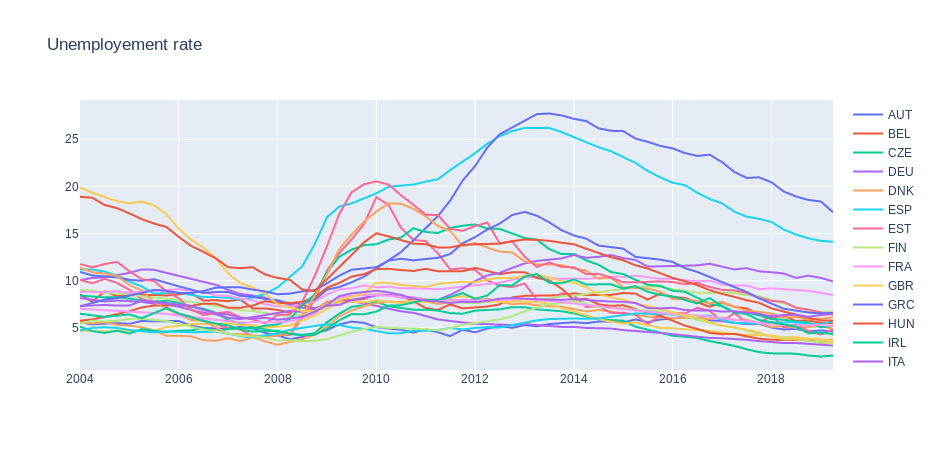

In [75]:
plot_lines(df_hur,0,"Unemployement rate")

We can see a fall until 2008, corresponding to the debt crisis in Europe. Following, we see a strong spike in unemployment, especially in Spain and Greece.
We can try to group countries with similar unemployement pattern using correlation distance and hierarchical clustering.

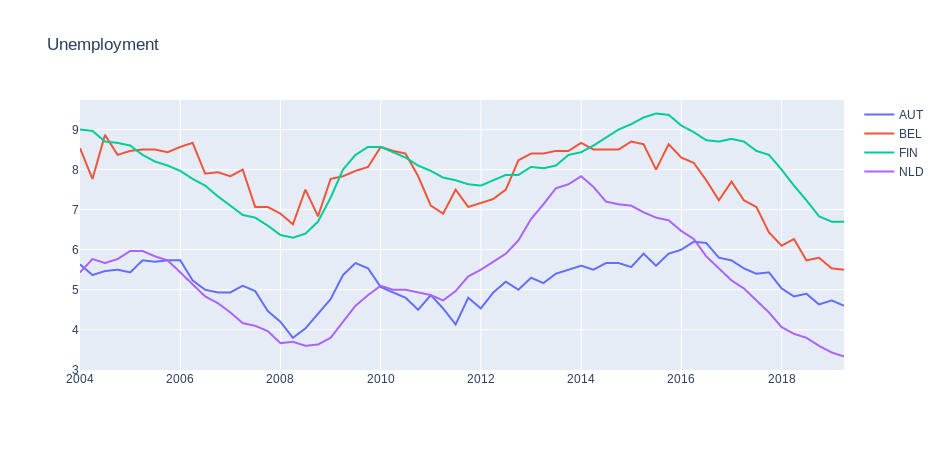

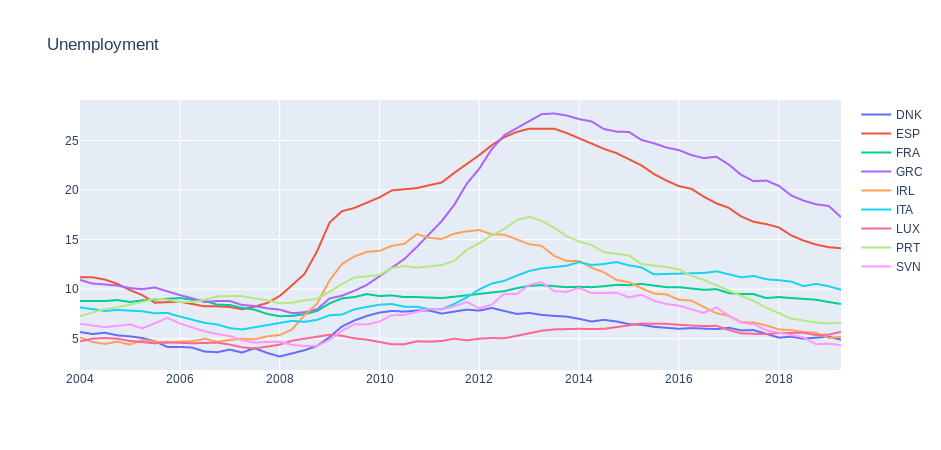

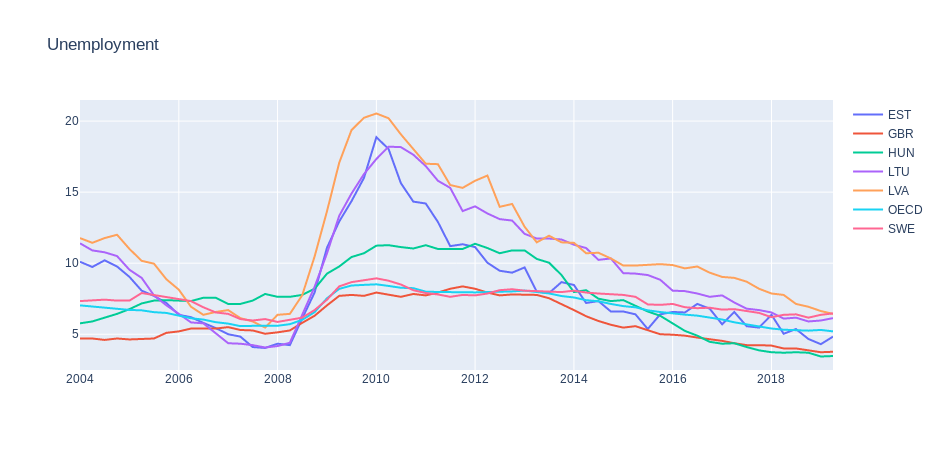

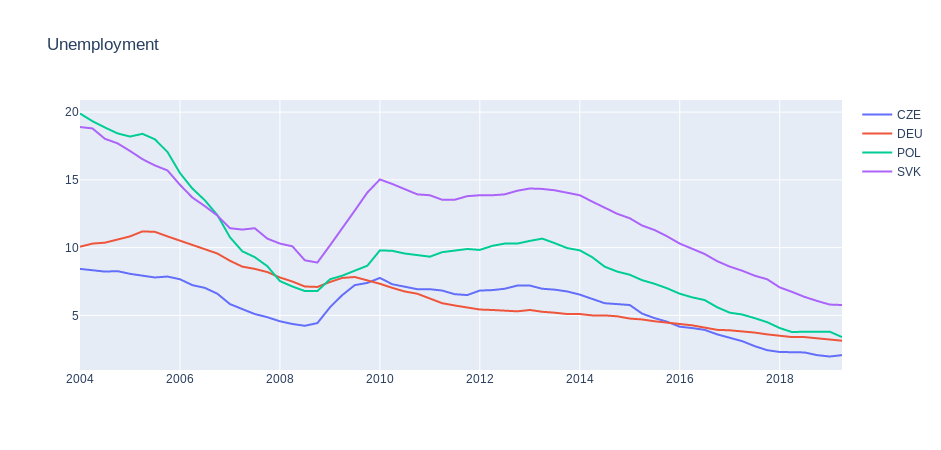

In [76]:
VAL_4_GROUPS = 0.65
df_corr_hur = df_hur.corr(method ='spearman')
idx = getIdx(df_corr_hur,VAL_4_GROUPS)
plotDifferentGroup(idx,df_hur,0,"Unemployment")

We can note that that these four groups have the following characteristics: group 1 has a fairly constant unemployment, group 2 has a peak around 2014, group 3 peaks around 2010, and group 4 has an increased but fairly constant unemployment during the 2010-2014 period.

The next data we gathered relates to economic information about households.

In [77]:
df = generate_df(names_h,PATH_H)
df = df_date_format_yearly(df)

In [78]:
df.head()

LOCATION        TIME  House_disp_inc_gross  House_spending_growth  \
6       NLD  2004-01-01          25432.337507               0.759912   
7       NLD  2005-01-01          25581.251359               0.910053   
8       NLD  2006-01-01          27538.958254              -0.155832   
9       NLD  2007-01-01          29054.251669               1.874667   
10      NLD  2008-01-01          30251.729176               0.890111   

    House_spending_total  House_net_worth  House_savings  House_debt  \
6            283540.6715         513.9053       4.273489    232.5928   
7            295006.6436         531.8785       2.488567    250.4763   
8            310922.7014         515.4900       1.793348    252.6498   
9            327515.3272         492.1235       1.754470    258.0443   
10           342367.8873         521.1525       3.629003    266.3608   

    House_assets_total  House_Disp_inc_growth  
6         90947.941397               0.446582  
7         97739.748721              -0.080236  
8        101046.115406               4.040303  
9        102404.910326               2.098755  
10       113442.910627               1.641266

We can visualize one of these values, for instance household debt.

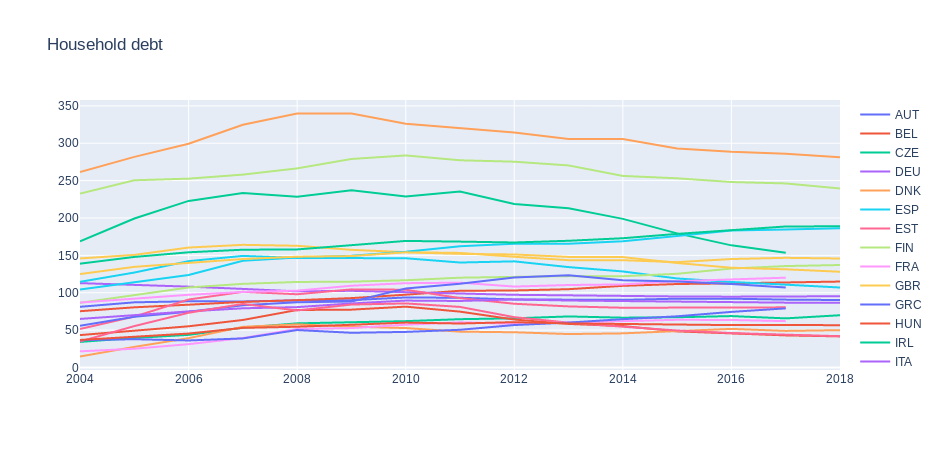

In [79]:
column = "House_debt"
df_debt = df[["LOCATION","TIME",column]].pivot_table(values=column, index='TIME', columns='LOCATION')
plot_lines(df_debt,0,"Household debt")

# 4. Animal care

For the same reason as the global ecology awareness, the interest about animal care is hard to measure.
We gathered data from Google Trends over multiple subjects:
- animal care
- L214 (French association for animal protection)
- slaughtering
- specism
- vegan cook
- vegetarism
- veganism
- meat substitue

In [80]:
pytrends = TrendReq(hl='en-US', tz=360)

#topics list 
kw_list = []
kw_list.append(["/m/032nch"]) #subject: animal care
kw_list.append(["l214"]) #keyword: l214 (French animal care association)
kw_list.append(["/m/047v0jr"]) #slaughtering
kw_list.append(["/m/07628"]) #specism
kw_list.append(["/m/07_lq"]) #vegan cook
kw_list.append(["/m/07_jd"]) #vegetarism
kw_list.append(["/m/07_hy"]) #veganism
kw_list.append(["/m/020953"]) #meat substitute

In [81]:
#loading google trend data for subject in kw_list
for x in range(len(kw_list)):
    
    #adding just the first one
    pytrends.build_payload(kw_list[x], cat=0, timeframe='all', geo=country_list[0], gprop='')
    pytrends.interest_over_time()
    newDataframe = pytrends.interest_over_time()[kw_list[x]]
    listColumn = []
    listColumn.append(country_list[0])
        
    for y in range(1, len(country_list)): 
        pytrends.build_payload(kw_list[x], cat=0, timeframe='all', geo=country_list[y], gprop='')
        ledata = pytrends.interest_over_time()
        if not ledata.empty:
            ledata.drop(ledata.columns[len(ledata.columns)-1], axis=1, inplace=True)
            newDataframe = pd.concat([newDataframe, ledata], axis=1, join='inner')
            listColumn.append(country_list[y])

    newDataframe.columns = listColumn
    newDataframe = newDataframe[19:] #remove first strange Data
    newDataframe.to_pickle("./data_vinc/GoogleTrend"+str(x)+".pkl") 

In [82]:
#loading data
#df_animal_cruelty = pd.read_pickle("./data_vinc/GoogleTrend0.pkl")
df_l214 = pd.read_pickle("./data_vinc/GoogleTrend1.pkl")
#df_abattage = pd.read_pickle("./data_vinc/GoogleTrend2.pkl")
df_specism = pd.read_pickle("./data_vinc/GoogleTrend3.pkl")
df_vegan_cook = pd.read_pickle("./data_vinc/GoogleTrend4.pkl")
df_vegetarism = pd.read_pickle("./data_vinc/GoogleTrend5.pkl")
df_veganism = pd.read_pickle("./data_vinc/GoogleTrend6.pkl")
df_meat_substitute = pd.read_pickle("./data_vinc/GoogleTrend7.pkl")

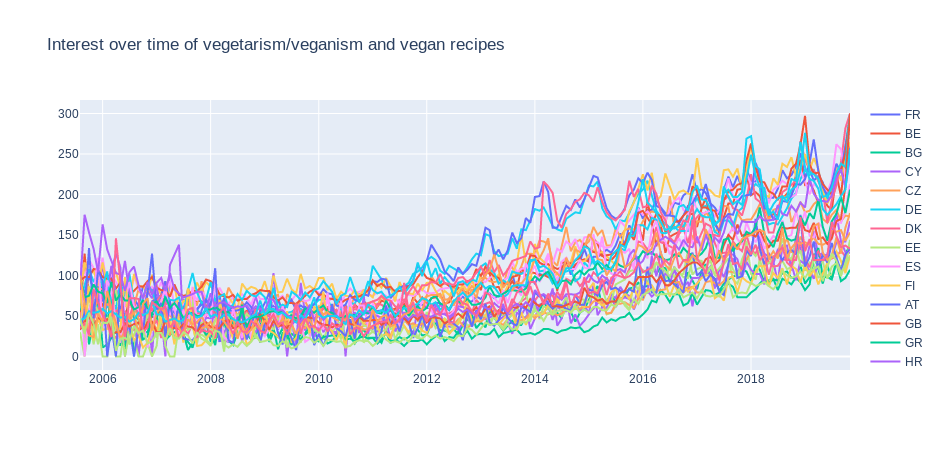

In [83]:
plot_lines((df_veganism+df_vegetarism+df_vegan_cook), 0, "Interest over time of vegetarism/veganism and vegan recipes")

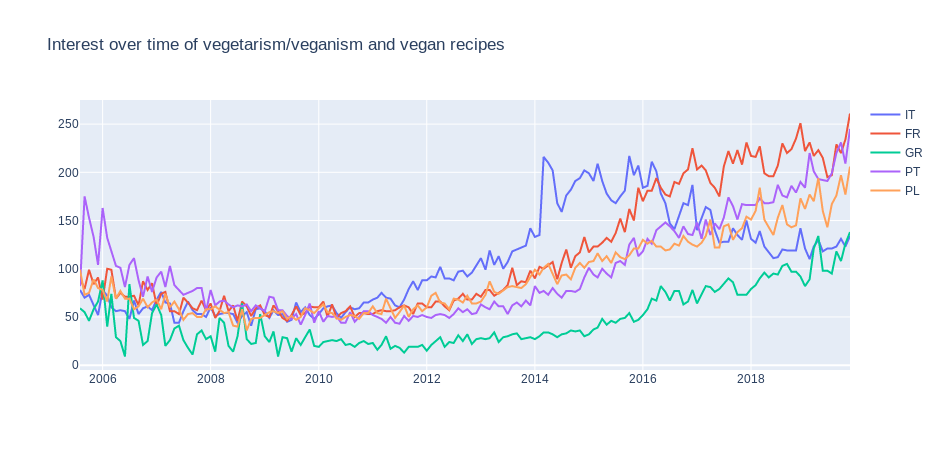

In [84]:
plot_lines((df_veganism+df_vegetarism+df_vegan_cook)[['IT', 'FR', 'GR', 'PT', 'PL']], 0, "Interest over time of vegetarism/veganism and vegan recipes")

As we can see the interest for this topic increased last 10 years.
The most interesting fact with google trend is the spikes we have at a precise month:

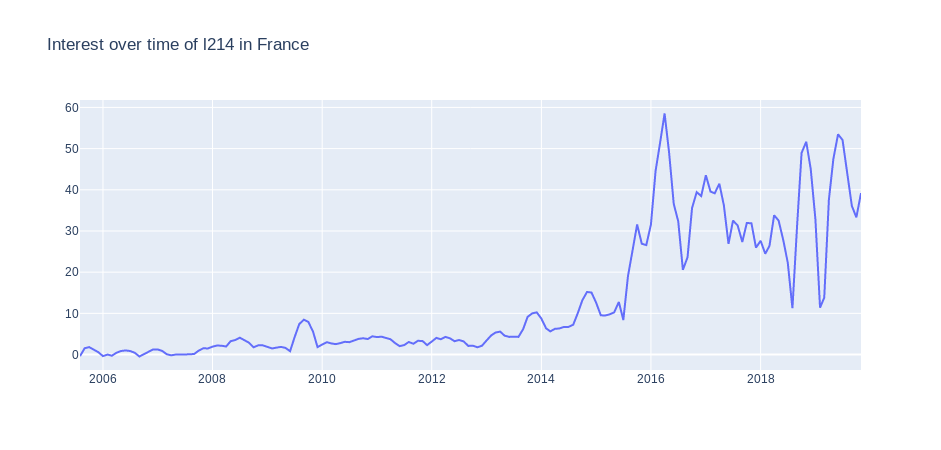

In [85]:
plot_lines(df_l214[['FR']], 7, "Interest over time of l214 in France")

Here we can see that something happened in France in April 2016 with the association L214, even the research for meat substitute has increased at that moment. What would be interesting is to find the exact event that happened at that moment.

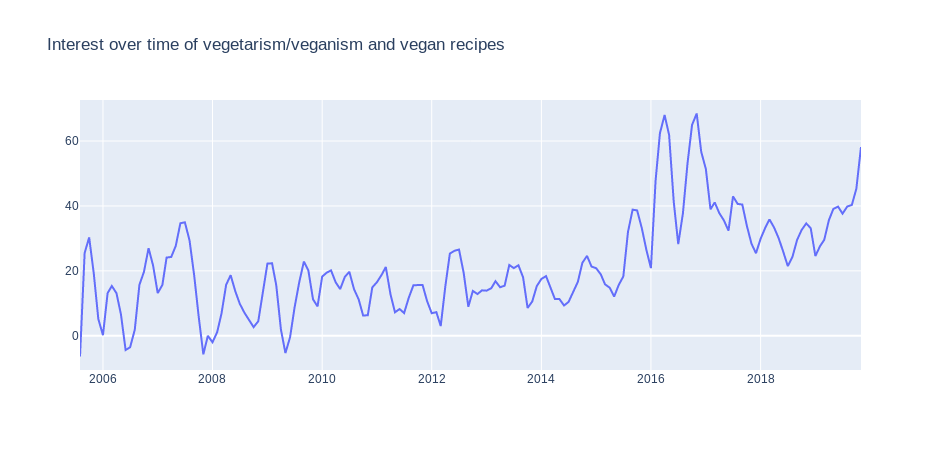

In [86]:
plot_lines(df_meat_substitute[['FR']], 7, "Interest over time of vegetarism/veganism and vegan recipes")

Even the research for the subject 'meat substitute' increased in April 2016.

They are also some curious curves, in Italy the interest for veganism increase significantly between 2013 and 2014. 

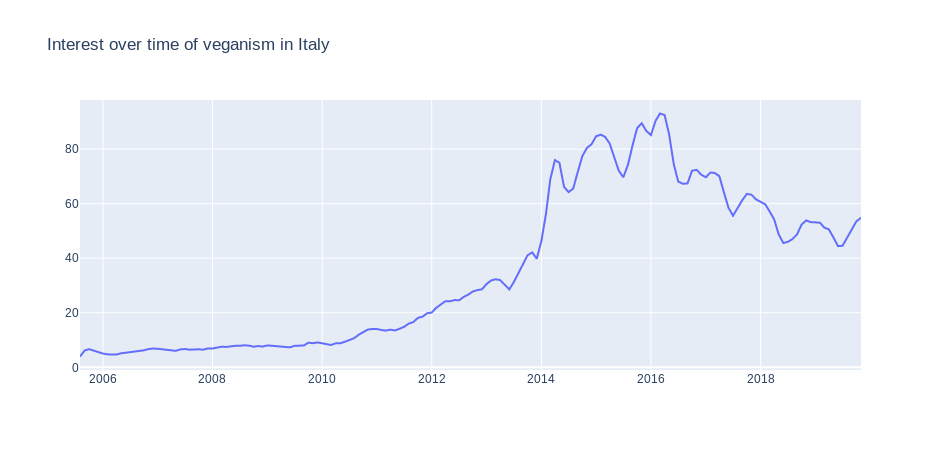

In [88]:
plot_lines(df_veganism[['IT']], 7, "Interest over time of veganism in Italy")

Some event clearly happenened when those researches exploded.

Also we can see some similar behaviours in those interests. K-means algorithm might be a first idea to cluster the differents countries:

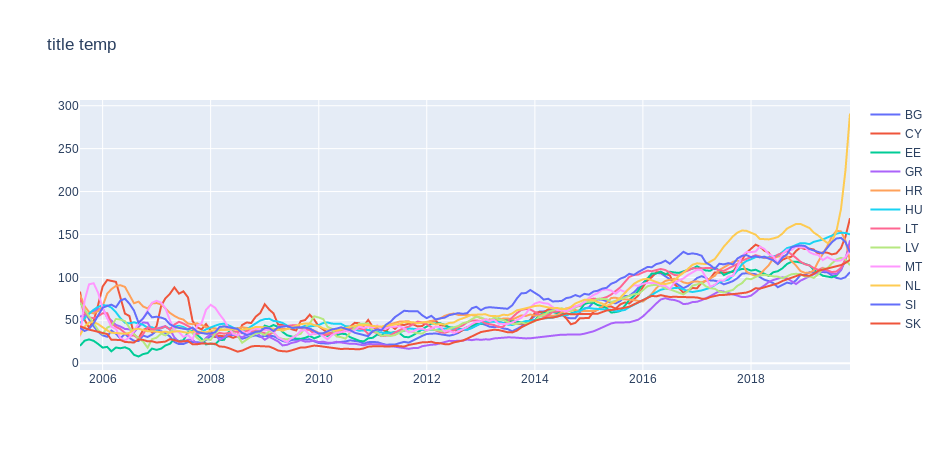

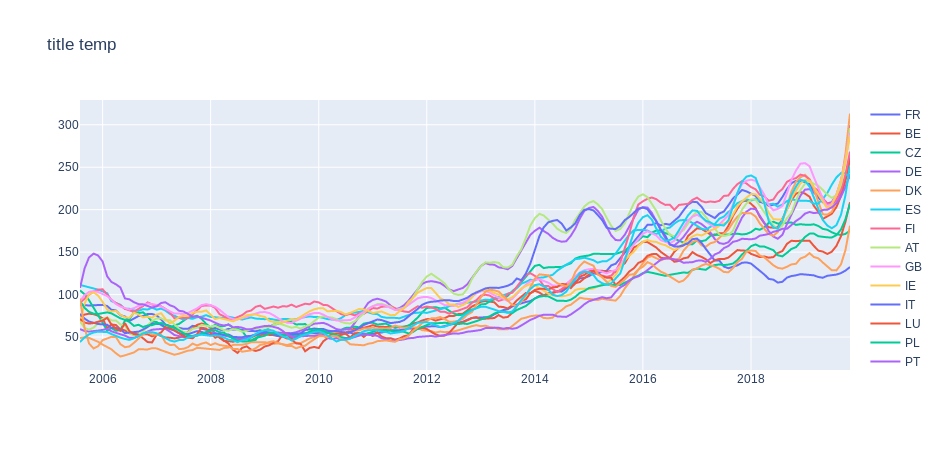

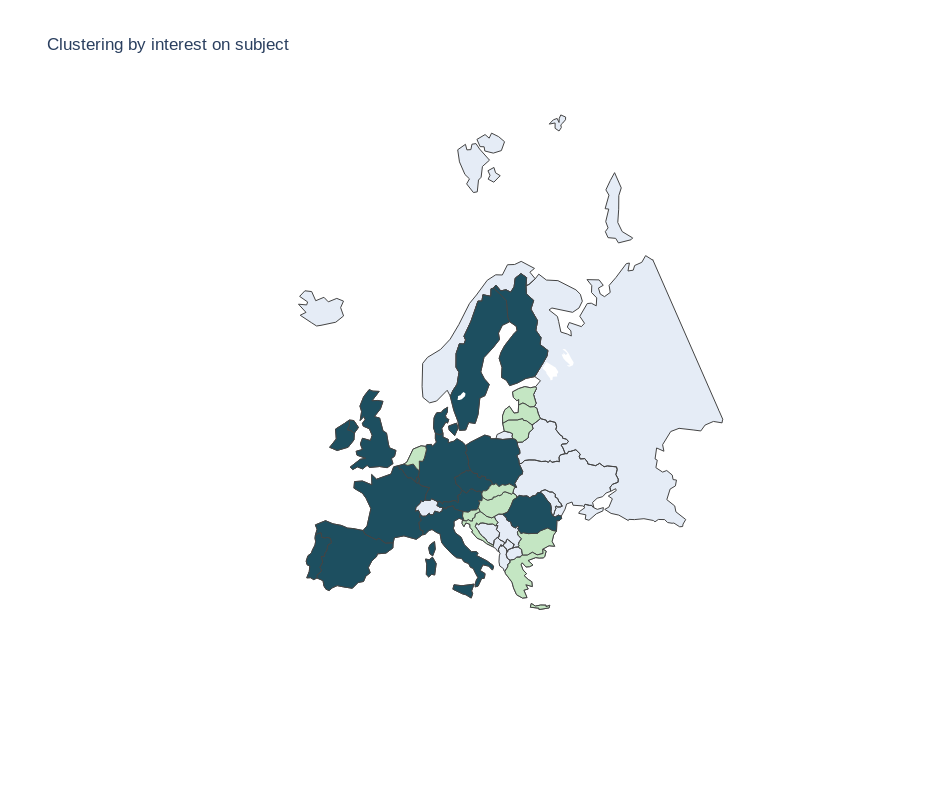

In [89]:
plotByGroup((df_veganism+df_vegetarism+df_vegan_cook), 'title temp', n_clusters=2, method='kmeans')

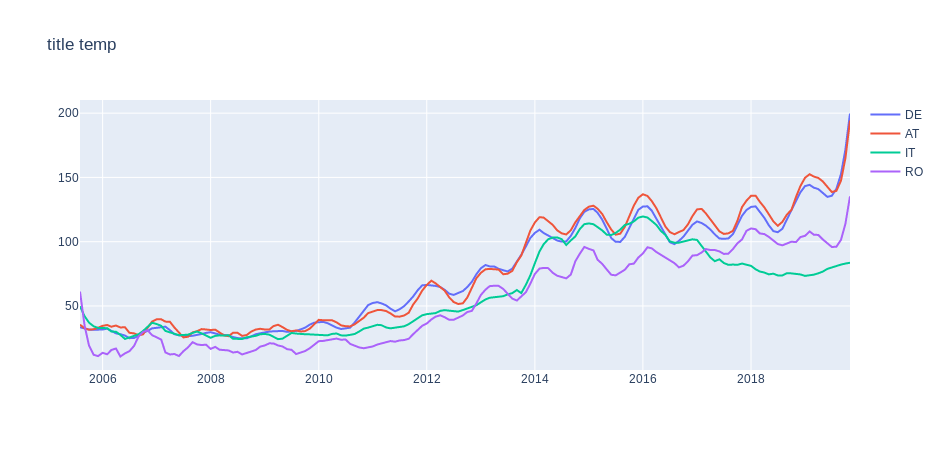

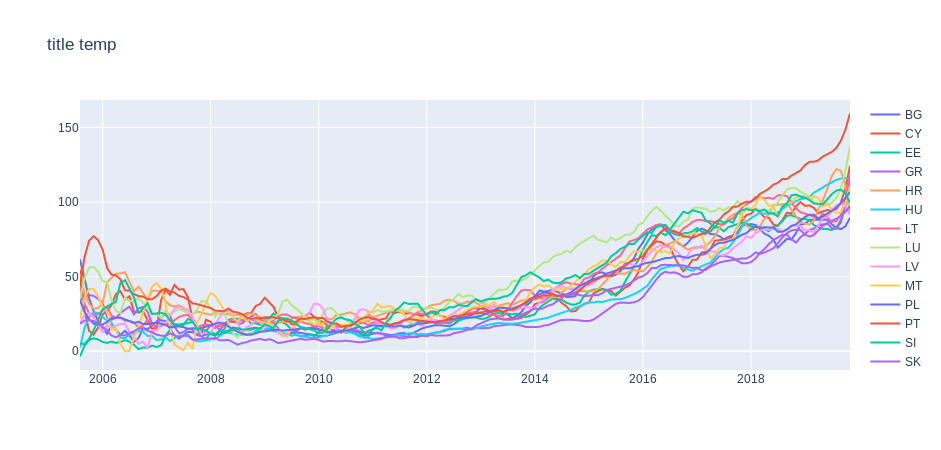

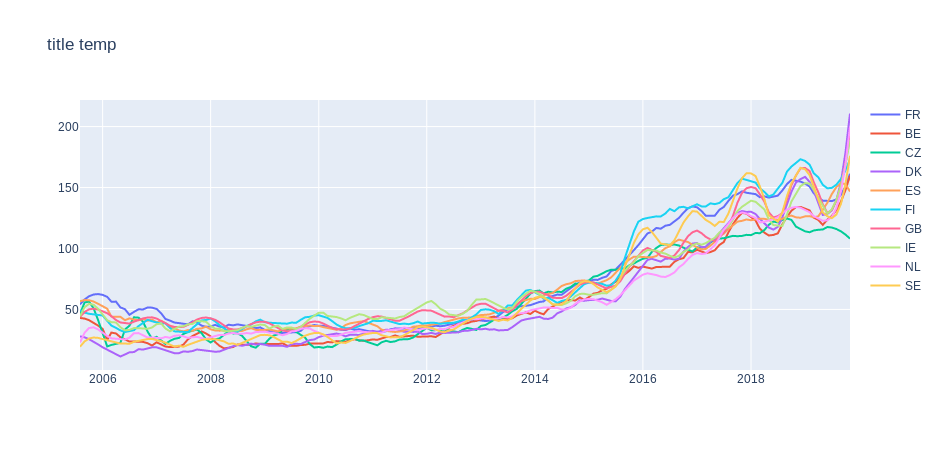

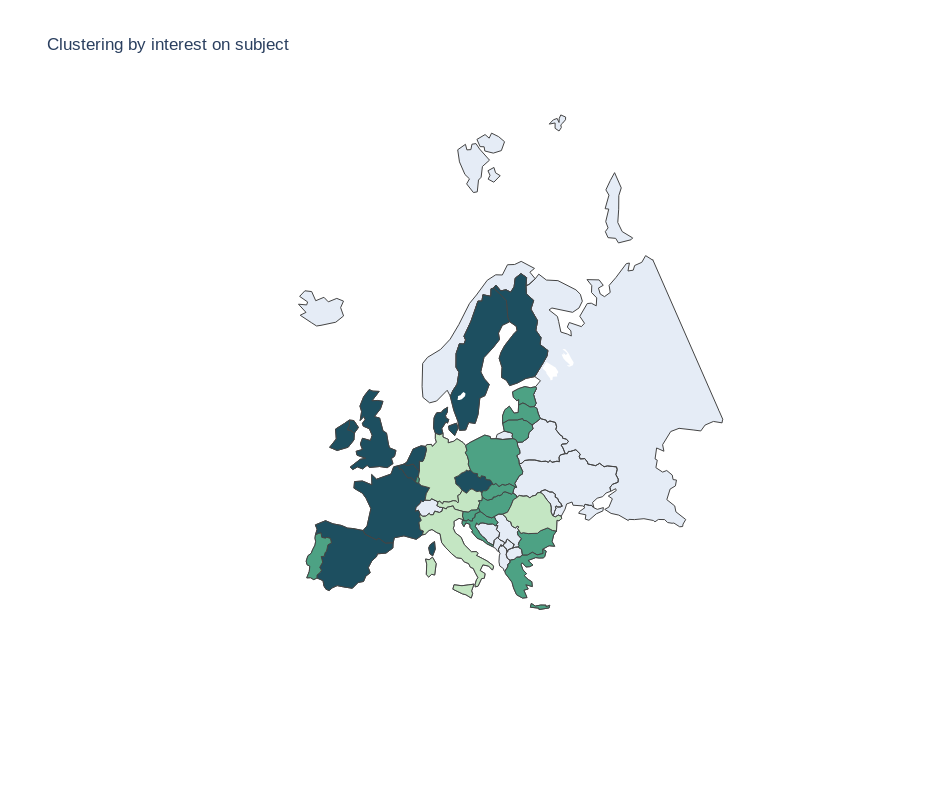

In [90]:
plotByGroup((df_veganism+df_vegan_cook), 'title temp', n_clusters=3, method='kmeans')

When we display the countries that are grouped together, we can see that they are geographicaly close to each other. It look like the cultural background of the countries has a lot of influence on the interest over our  topics.

# 5. Next steps

- Is there significant differences in meat consumption between countries in Europe ?
- A debt crisis occured in 2008 in Europe and certain countries were especially hard hit, such as Spain or Greece; do we see a change in their meat consumption during these periods ?
- Can we relate meat consumption to household informations ? For instance, is household income related to meat consumption ?
- Is there significant differences in meat consumption between countries in Europe and can we explain those differences with the other datasets?
- Can we make any link about the changes in the Google Trends data and the COP conferences ?
- A debt crisis occured in 2008 in Europe and certain countries were especially hard hit, such as Spain or Greece; do we see a change in their meat consumption during these periods ?
- Can we relate meat consumption to household informations ? For instance, is household income related to meat consumption ?
- We saw some spikes in the interest for the subjects "Veganism", "Vegetarism" and "Vegan Recipes". What events provoked this ?
- Can we find something related to those spikes in the other datasets ?
- Does the increasing interest for the subjects "Veganism", "Vegetarism" and "Vegan Recipes" have an impact on meat consumption ?
- Why do we see in Italy a sudden increase for the subject "veganism" ?
- Does the geometrical results we obtained with k-means actually make sense if we compare the countries with the data of our other datasets ?